In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
from iSDR_cython import linear_model
from scipy.io import loadmat
np.random.seed(12)

In [2]:
data = loadmat('S1_EEG.mat')

In [3]:
clf = linear_model.iSDRcv(l21_values=np.logspace(-1, 1.3, 15),
                          la_values=np.logspace(-1, 1, 10),
                          la_ratio_values=[1, 0.99],
                          normalize=[0],
                          model_p=[1,2],
                          old_version=False,
                          normalize_Astep=[0],
                          normalize_Sstep=[0],
                          cv=None,
                          parallel=True,
                          criterion='bic'
                         )
clf.run(data['G'].astype(np.float32), data['M'].astype(np.float32), data['SC'])

Successfully created the directory /tmp/tmp_bf40c5bd-4bbf-4996-9807-e24766d8b586 


100%|██████████| 70/70 [22:09<00:00, 19.00s/it]  

Successfully deleted the directory /tmp/tmp_bf40c5bd-4bbf-4996-9807-e24766d8b586


clf.time

In [7]:
clf.results['ls_reg'] = np.log10(clf.results['ls_reg'])

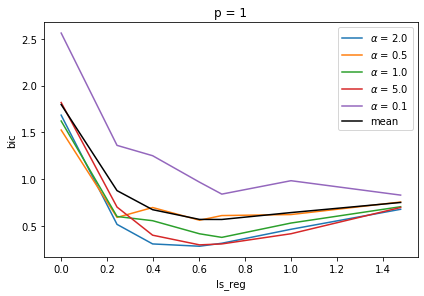

             rms  nbr   S_prior  A_prior_l1   A_prior_l2    ls_reg  la_reg_a  \
runidx                                                                         
10      1.399651   31  0.000025  269.826172  1394.181032  1.477121       0.1   

        la_reg_r        la  p  normalize      l21_real  normalize_Astep  \
runidx                                                                    
10           1.0  0.000078  1          0  8.059556e+07                0   

        normalize_Sstep  nbr_coef          Obj       bic  
runidx                                                    
10                    0       123  2008.065976  0.830462  


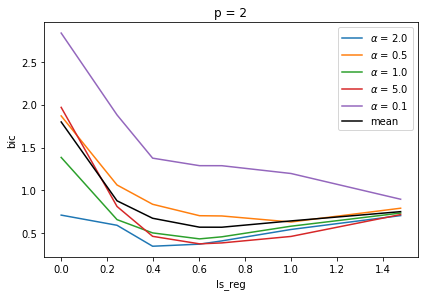

             rms  nbr   S_prior  A_prior_l1   A_prior_l2    ls_reg  la_reg_a  \
runidx                                                                         
64      1.477241   30  0.000021  344.239624  1593.653462  1.477121       0.1   

        la_reg_r        la  p  normalize      l21_real  normalize_Astep  \
runidx                                                                    
64           1.0  0.000079  2          0  8.059556e+07                0   

        normalize_Sstep  nbr_coef          Obj       bic  
runidx                                                    
64                    0       160  1690.972259  0.896627  


In [20]:
#plt.plot(clf.results.ls_reg, clf.results[criterion]/(n_t*69), '*')
import seaborn as sns
criterion = 'bic'
for p in  [1, 2]:
    for i in clf.results.la_reg_a.unique():
        df = clf.results[clf.results.la_reg_a == i]
        df = df[df.p == p]
        sns.lineplot(x='ls_reg', y='bic', data=df, label=r'$\alpha$ = %s'%i)
    dx = clf.results.groupby(['ls_reg']).mean()
    dx.reset_index(inplace=True)
    sns.lineplot(x='ls_reg', y='bic', data=dx, label='mean', color='k')
    plt.tight_layout()
    plt.title('p = '+str(p))
    plt.show()
    op = df[df[criterion] == df[criterion].min()]
    print(op)

In [16]:
np.logspace(-1, 1, 10)

array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
        1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ])